# Usefull imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

# Import main dataset

In [3]:
# First let's create a copy of our data
data=pd.read_csv('regularite-mensuelle-tgv-aqst.csv',delimiter=';')
df = data.copy()
df = df[(df['duree_moyenne'] > 0)]
df[['année', 'mois']] = df['date'].str.split('-', expand=True).astype(int)
remove_columns_0 = ['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs', 'commentaire_annulation', 'commentaire_retards_depart', 'commentaires_retard_arrivee']
remove_columns_1 = remove_columns_0 + ['retard_moyen_tous_trains_arrivee']
remove_columns_2 = remove_columns_1 + ['nb_train_retard_sup_15' , 'retard_moyen_trains_retard_sup15' , 'nb_train_retard_sup_30' , 'nb_train_retard_sup_60']
remove_columns_3 = remove_columns_2 + ['nb_train_retard_arrivee']
remove_columns_4 = remove_columns_3 + ['nb_train_depart_retard' , 'retard_moyen_depart' , 'retard_moyen_tous_trains_depart']
remove_columns_5 = remove_columns_4 + ['nb_annulation']
# Cleaning the data
df = clean_data(df,remove_columns_3)
df.head()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,retard_moyen_arrivee,année,mois
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,289,11.247809,3.693179,28.436735,2018,1
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,8,2.875000,0.095796,21.524020,2018,1
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,1.003981,55.692308,2018,1
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,12,19.912500,1.966667,48.623077,2018,1
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,61,7.796995,0.886889,12.405164,2018,1


# Data Preprocessing 

In [4]:
#Splitting the data
test_data2 = select_test_data(df)
train_data2 = select_train_data(df,test_data2)

# We drop the date column to keep only the features we will use
train_data2=train_data2.drop(columns=['date'],axis=1)
test_data2=test_data2.drop(columns=['date'],axis=1)

train_data2 = train_data2[(train_data2.gare_depart == 'BORDEAUX ST JEAN') & (train_data2.gare_arrivee == 'PARIS MONTPARNASSE')]
train_data2 = clean_data(train_data2,['gare_depart', 'gare_arrivee'])
test_data2 = test_data2[(test_data2.gare_depart == 'BORDEAUX ST JEAN') & (test_data2.gare_arrivee == 'PARIS MONTPARNASSE')]
test_data2 = clean_data(test_data2,['gare_depart', 'gare_arrivee'])

target_columns=['retard_moyen_arrivee']
y_train2=target_fun(train_data2,target_columns)
y_test2=target_fun(test_data2,target_columns)

X_train2=features(train_data2,target_columns)
X_test2=features(test_data2,target_columns)

# Train one Model

## GridSearchCV with RF

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Créez une pipeline avec StandardScaler, PolynomialFeatures et XGBoost
numeric_features = ['duree_moyenne', 'nb_train_prevu', 'nb_annulation', 'nb_train_depart_retard', 'retard_moyen_depart',
       'retard_moyen_tous_trains_depart', 'mois']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestRegressor())
])

# Définissez la grille d'hyperparamètres à explorer
param_grid = {
    'random_forest__n_estimators': [5, 10 , 25, 50],  # Nombre d'arbres
    'random_forest__max_depth': [2, 5, 10, 20],  # Profondeur maximale de l'arbre
    'random_forest__max_features' : ['sqrt', 'log2', None]
}

# Créez un objet GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajustez la pipeline sur l'ensemble d'apprentissage
grid_search.fit(X_train2, y_train2)

# Obtenez les meilleurs hyperparamètres
best_params = grid_search.best_params_
print("Meileurs hyperparamètres:", best_params)

# Prédisez les pourcentages de causes sur l'ensemble de test
y_pred = grid_search.predict(X_test2)

# Évaluez la performance du modèle (par exemple, en utilisant l'erreur quadratique moyenne)
rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

Meileurs hyperparamètres: {'random_forest__max_depth': 2, 'random_forest__max_features': None, 'random_forest__n_estimators': 10}
Root Mean Squared Error (RMSE): 7.679971487093094


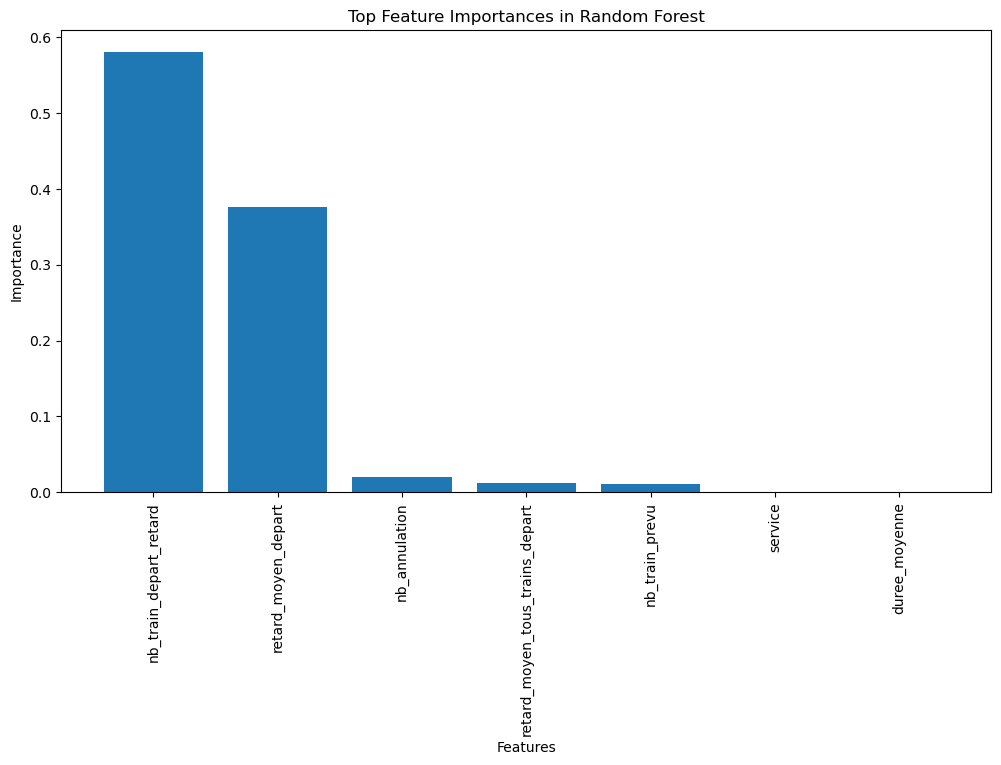

In [6]:
# Get feature importances from the model
feature_importances = grid_search.best_estimator_.named_steps['random_forest'].feature_importances_

# Create a dictionary to map feature names to their importances
feature_importance_dict = dict(zip(X_train2.columns, feature_importances))

# Sort the features by importance in descending order
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Number of top features to display
top_n = 20  

# Extract the top features and their importances
top_features = [feature[0] for feature in sorted_features[:top_n]]
top_importances = [feature[1] for feature in sorted_features[:top_n]]

# Create a bar plot to visualize the top feature importances
plt.figure(figsize=(12, 6))
plt.bar(top_features, top_importances)
plt.xticks(rotation=90)
plt.title('Top Feature Importances in Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Train all models with RF

In [ ]:
gares = df[['gare_depart', 'gare_arrivee']].drop_duplicates()
gares = list(zip(gares['gare_depart'], gares['gare_arrivee']))

mean_squared_error_list = {}
r2_list = {}
mean_abs_error_list = {}

numeric_features = ['duree_moyenne', 'nb_train_prevu', 'nb_annulation', 'nb_train_depart_retard', 'retard_moyen_depart',
           'retard_moyen_tous_trains_depart', 'mois']
# Définissez la grille d'hyperparamètres à explorer
param_grid = {
    'random_forest__max_depth': [2, 5, 10, 20],  # Profondeur maximale de l'arbre
    'random_forest__max_features' : ['sqrt', 'log2', None]
}

for gare_depart, gare_arrivee in gares :
    print(gare_depart, ' -------> ', gare_arrivee)
    
    #Splitting the data
    test_data2 = select_test_data(df)
    train_data2 = select_train_data(df,test_data2)

    # We drop the date column to keep only the features we will use
    train_data2=train_data2.drop(columns=['date'],axis=1)
    test_data2=test_data2.drop(columns=['date'],axis=1)

    train_data2 = train_data2[(train_data2.gare_depart == gare_depart) & (train_data2.gare_arrivee == gare_arrivee)]
    train_data2 = clean_data(train_data2,['gare_depart', 'gare_arrivee'])
    test_data2 = test_data2[(test_data2.gare_depart == gare_depart) & (test_data2.gare_arrivee == gare_arrivee)]
    test_data2 = clean_data(test_data2,['gare_depart', 'gare_arrivee'])

    if test_data2.size > 0 :
        target_columns=['retard_moyen_arrivee']
        y_train2=target_fun(train_data2,target_columns)
        y_test2=target_fun(test_data2,target_columns)

        X_train2=features(train_data2,target_columns)
        X_test2=features(test_data2,target_columns)

        # Créez une pipeline avec StandardScaler, PolynomialFeatures et XGBoost
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features)
            ])
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('random_forest', RandomForestRegressor(n_estimators = 100))
        ])

        # Créez un objet GridSearchCV pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

        # Ajustez la pipeline sur l'ensemble d'apprentissage
        grid_search.fit(X_train2, y_train2)

        # Obtenez les meilleurs hyperparamètres
        best_params = grid_search.best_params_
        print("Meileurs hyperparamètres:", best_params)

        # Prédisez les pourcentages de causes sur l'ensemble de test
        y_pred = grid_search.predict(X_test2)

        # Évaluez la performance du modèle (par exemple, en utilisant l'erreur quadratique moyenne)
        rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
        mean_squared_error_list[(gare_depart, gare_arrivee)] = rmse
        print("Root Mean Squared Error (RMSE):", rmse)
        r2 = r2_score(y_test2, y_pred)
        r2_list[(gare_depart, gare_arrivee)] = r2
        print("R²:", r2)
        mae = mean_absolute_error(y_test2, y_pred)
        mean_abs_error_list[(gare_depart, gare_arrivee)] = mae
        print("MAE:", mae)
    else :
        print("Empty Test Set")

In [ ]:
import statistics

plt.plot(sorted(list((mean_squared_error_list.values()))), label = "RMSE")
plt.axhline(y=statistics.mean(list((mean_squared_error_list.values()))), color='r', linestyle='--', label='RMSE_mean')
plt.plot(sorted(list((mean_abs_error_list.values()))), label = "MAE")
plt.axhline(y=statistics.mean(list((mean_abs_error_list.values()))), color='g', linestyle='--', label='MAE_mean')
plt.ylim(0, 30)
plt.grid()
plt.legend()
plt.title("Niveau de restriction 3")

# Train all models with LinearRegressor

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

gares = df[['gare_depart', 'gare_arrivee']].drop_duplicates()
gares = list(zip(gares['gare_depart'], gares['gare_arrivee']))

mean_squared_error_list = {}
r2_list = {}
mean_abs_error_list = {}

numeric_features = ['duree_moyenne', 'nb_train_prevu', 'nb_annulation', 'nb_train_depart_retard', 'retard_moyen_depart',
           'retard_moyen_tous_trains_depart', 'mois']
# Définissez la grille d'hyperparamètres à explorer
param_grid = {'selectkbest__k': [1, 2, 3, 4, 5, 6, 7]}


for gare_depart, gare_arrivee in gares :
    print(gare_depart, ' -------> ', gare_arrivee)
    
    #Splitting the data
    test_data2 = select_test_data(df)
    train_data2 = select_train_data(df,test_data2)

    # We drop the date column to keep only the features we will use
    train_data2=train_data2.drop(columns=['date'],axis=1)
    test_data2=test_data2.drop(columns=['date'],axis=1)

    train_data2 = train_data2[(train_data2.gare_depart == gare_depart) & (train_data2.gare_arrivee == gare_arrivee)]
    train_data2 = clean_data(train_data2,['gare_depart', 'gare_arrivee'])
    test_data2 = test_data2[(test_data2.gare_depart == gare_depart) & (test_data2.gare_arrivee == gare_arrivee)]
    test_data2 = clean_data(test_data2,['gare_depart', 'gare_arrivee'])

    if test_data2.size > 0 :
        target_columns=['retard_moyen_arrivee']
        y_train2=target_fun(train_data2,target_columns)
        y_test2=target_fun(test_data2,target_columns)

        X_train2=features(train_data2,target_columns)
        X_test2=features(test_data2,target_columns)

        # Créez une pipeline avec StandardScaler, PolynomialFeatures et XGBoost
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features)
            ])
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('selectkbest', SelectKBest(score_func = f_regression)),
            ('linear_regressor', LinearRegression())
        ])

        # Créez un objet GridSearchCV pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

        # Ajustez la pipeline sur l'ensemble d'apprentissage
        grid_search.fit(X_train2, y_train2)

        # Obtenez les meilleurs hyperparamètres
        best_params = grid_search.best_params_
        print("Meileurs hyperparamètres:", best_params)

        # Prédisez les pourcentages de causes sur l'ensemble de test
        y_pred = grid_search.predict(X_test2)

        # Évaluez la performance du modèle (par exemple, en utilisant l'erreur quadratique moyenne)
        rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
        mean_squared_error_list[(gare_depart, gare_arrivee)] = rmse
        print("Root Mean Squared Error (RMSE):", rmse)
        r2 = r2_score(y_test2, y_pred)
        r2_list[(gare_depart, gare_arrivee)] = r2
        print("R²:", r2)
        mae = mean_absolute_error(y_test2, y_pred)
        mean_abs_error_list[(gare_depart, gare_arrivee)] = mae
        print("MAE:", mae)
    else :
        print("Empty Test Set")

BORDEAUX ST JEAN  ------->  PARIS MONTPARNASSE
Meileurs hyperparamètres: {'selectkbest__k': 4}
Root Mean Squared Error (RMSE): 7.500018918774429
R²: 0.1990575113930424
MAE: 6.8657973506783385
LA ROCHELLE VILLE  ------->  PARIS MONTPARNASSE
Meileurs hyperparamètres: {'selectkbest__k': 2}
Root Mean Squared Error (RMSE): 12.355105383331926
R²: 0.533031400932535
MAE: 8.980700334333385
PARIS MONTPARNASSE  ------->  QUIMPER
Meileurs hyperparamètres: {'selectkbest__k': 2}
Root Mean Squared Error (RMSE): 13.569526650156776
R²: -0.6760305633493193
MAE: 11.418629401565477
PARIS MONTPARNASSE  ------->  ST MALO
Meileurs hyperparamètres: {'selectkbest__k': 7}
Root Mean Squared Error (RMSE): 9.105003506536677
R²: 0.336488583863948
MAE: 7.152568974289266
PARIS MONTPARNASSE  ------->  ST PIERRE DES CORPS
Meileurs hyperparamètres: {'selectkbest__k': 1}
Root Mean Squared Error (RMSE): 5.593510761118767
R²: 0.619903021626657
MAE: 4.372210794118572
QUIMPER  ------->  PARIS MONTPARNASSE
Meileurs hyperparam

Meileurs hyperparamètres: {'selectkbest__k': 7}
Root Mean Squared Error (RMSE): 9.325482063842575
R²: 0.0944761777402855
MAE: 7.433155759634114
MONTPELLIER  ------->  LYON PART DIEU
Meileurs hyperparamètres: {'selectkbest__k': 1}
Root Mean Squared Error (RMSE): 7.220380623875677
R²: -0.17167621403370048
MAE: 6.585911879037611
PARIS LYON  ------->  MARSEILLE ST CHARLES
Meileurs hyperparamètres: {'selectkbest__k': 1}
Root Mean Squared Error (RMSE): 8.738550161424008
R²: 0.2129989452720359
MAE: 6.901501280234522
PARIS LYON  ------->  MULHOUSE VILLE
Meileurs hyperparamètres: {'selectkbest__k': 1}
Root Mean Squared Error (RMSE): 17.642637029089606
R²: -0.099046386607329
MAE: 11.37212865241501
PARIS LYON  ------->  VALENCE ALIXAN TGV
Meileurs hyperparamètres: {'selectkbest__k': 1}
Root Mean Squared Error (RMSE): 4.1317007786823385
R²: 0.5905825336477732
MAE: 3.52673417371521
PERPIGNAN  ------->  PARIS LYON
Meileurs hyperparamètres: {'selectkbest__k': 1}
Root Mean Squared Error (RMSE): 15.862

Meileurs hyperparamètres: {'selectkbest__k': 6}
Root Mean Squared Error (RMSE): 3.2974746899550875
R²: -0.28930948229767295
MAE: 2.556954360062573
PARIS LYON  ------->  AVIGNON TGV
Meileurs hyperparamètres: {'selectkbest__k': 1}
Root Mean Squared Error (RMSE): 7.474202345991576
R²: 0.25802221713682716
MAE: 5.837494735571987
PARIS LYON  ------->  BELLEGARDE (AIN)
Meileurs hyperparamètres: {'selectkbest__k': 4}
Root Mean Squared Error (RMSE): 5.323093279638668
R²: 0.14709687383007797
MAE: 4.429307371245458
PARIS LYON  ------->  BESANCON FRANCHE COMTE TGV
Meileurs hyperparamètres: {'selectkbest__k': 2}
Root Mean Squared Error (RMSE): 6.46695152152328
R²: 0.698410985783028
MAE: 5.456516324669426
PARIS LYON  ------->  DIJON VILLE
Meileurs hyperparamètres: {'selectkbest__k': 6}
Root Mean Squared Error (RMSE): 6.180368072374909
R²: 0.6291636809969351
MAE: 5.518201374066369
PARIS LYON  ------->  MONTPELLIER
Meileurs hyperparamètres: {'selectkbest__k': 4}
Root Mean Squared Error (RMSE): 9.53794

In [19]:
pd.DataFrame(mean_squared_error_list.items(), columns=['gare_départ_arrivée', 'RMSE']).merge(pd.DataFrame(mean_abs_error_list.items(), columns=['gare_départ_arrivée', 'MAE']), how='inner').head(20)

,gare_départ_arrivée,RMSE,MAE
0,"(BORDEAUX ST JEAN, PARIS MONTPARNASSE)",7.500019,6.865797
1,"(LA ROCHELLE VILLE, PARIS MONTPARNASSE)",12.355105,8.980700
2,"(PARIS MONTPARNASSE, QUIMPER)",13.569527,11.418629
3,"(PARIS MONTPARNASSE, ST MALO)",9.105004,7.152569
4,"(PARIS MONTPARNASSE, ST PIERRE DES CORPS)",5.593511,4.372211
5,"(QUIMPER, PARIS MONTPARNASSE)",23.077983,17.862656
6,"(RENNES, LYON PART DIEU)",31.773959,20.814784
7,"(ST PIERRE DES CORPS, PARIS MONTPARNASSE)",8.623316,6.309163
8,"(TOURS, PARIS MONTPARNASSE)",6.354751,3.754992
9,"(NANTES, STRASBOURG)",14.248291,11.190637


Text(0.5, 1.0, 'Niveau de restriction 3')

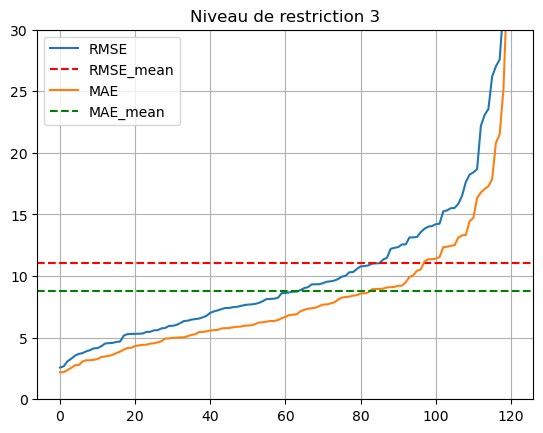

In [21]:
import statistics

plt.plot(sorted(list((mean_squared_error_list.values()))), label = "RMSE")
plt.axhline(y=statistics.mean(list((mean_squared_error_list.values()))), color='r', linestyle='--', label='RMSE_mean')
plt.plot(sorted(list((mean_abs_error_list.values()))), label = "MAE")
plt.axhline(y=statistics.mean(list((mean_abs_error_list.values()))), color='g', linestyle='--', label='MAE_mean')
plt.ylim(0, 30)
plt.grid()
plt.legend()
plt.title("Niveau de restriction 3")

## Analyser un cas où le modele est faible

In [78]:
#Splitting the data
test_data2 = select_test_data(df)
train_data2 = select_train_data(df,test_data2)

# We drop the date column to keep only the features we will use
train_data2=train_data2.drop(columns=['date'],axis=1)
test_data2=test_data2.drop(columns=['date'],axis=1)

train_data2 = train_data2[(train_data2.gare_depart == 'TOURCOING') & (train_data2.gare_arrivee == 'BORDEAUX ST JEAN')]
train_data2 = clean_data(train_data2,['gare_depart', 'gare_arrivee'])
test_data2 = test_data2[(test_data2.gare_depart == 'TOURCOING') & (test_data2.gare_arrivee == 'BORDEAUX ST JEAN')]
test_data2 = clean_data(test_data2,['gare_depart', 'gare_arrivee'])

if test_data2.size > 0 :
    target_columns=['retard_moyen_arrivee']
    y_train2=target_fun(train_data2,target_columns)
    y_test2=target_fun(test_data2,target_columns)

    X_train2=features(train_data2,target_columns)
    X_test2=features(test_data2,target_columns)

    # Créez une pipeline avec StandardScaler, PolynomialFeatures et XGBoost
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('selectkbest', SelectKBest(score_func=f_regression, k=7)),
        ('linear_regressor', LinearRegression())
    ])

    # Ajustez la pipeline sur l'ensemble d'apprentissage
    pipeline.fit(X_train2, y_train2)

    # Prédisez les pourcentages de causes sur l'ensemble de test
    y_pred = pipeline.predict(X_test2)

    # Évaluez la performance du modèle (par exemple, en utilisant l'erreur quadratique moyenne)
    rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
    mean_squared_error_list[(gare_depart, gare_arrivee)] = rmse
    print("Root Mean Squared Error (RMSE):", rmse)
    r2 = r2_score(y_test2, y_pred)
    r2_list[(gare_depart, gare_arrivee)] = r2
    print("R²:", r2)
    mae = mean_absolute_error(y_test2, y_pred)
    mean_abs_error_list[(gare_depart, gare_arrivee)] = mae
    print("MAE:", mae)
else :
    print("Empty Test Set")

Root Mean Squared Error (RMSE): 139.0127409349328
R²: -0.546136757016441
MAE: 109.7965513638948


<Axes: >

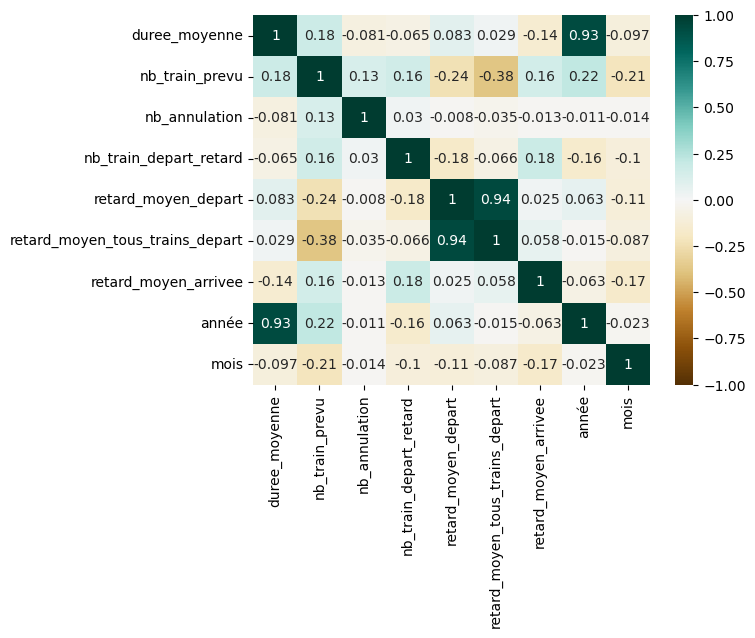

In [80]:
sns.heatmap(train_data2.drop(['service'], axis = 1).corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')